# Swath-to-Grid Regridding Pipeline

## Overview
This notebook demonstrates the regridding of 1-dimensional satellite swath data onto 2-dimensional 
EASE-Grid 2.0 (Equal-Area Scalable Earth Grid) at 50km resolution for the Southern Hemisphere.

## Objectives
1. Load and preprocess satellite altimetry swath data (Cryo-TEMPO, CCI, LEGOS, CSAO)
2. Project swath observations onto the EASE-Grid 2.0 Southern Hemisphere 50km grid
3. Compute monthly and annual mean statistics for sea-ice freeboard variables
4. Validate projections through visualization and inter-product comparison

## Data Sources
- **Cryo-TEMPO**: ESA CryoSat-2 Thematic Ocean Product (L2P daily)
- **ESA CCI**: Climate Change Initiative Sea Ice Thickness (L3C monthly)
- **LEGOS**: Laboratoire d'Etudes en Géophysique et Océanographie Spatiales
- **CSAO**: CryoSat-2 Antarctic Ocean dataset

## Requirements
- Python 3.8+
- Libraries: `netCDF4`, `pyresample`, `xarray`, `numpy`, `matplotlib`, `cartopy`, `cmocean`

---
**Author**: [Your Name]  
**Version**: 1.0.0  
**Last Updated**: 2025-12-08

In [1]:
# Importing the necessary libraries
from netCDF4 import Dataset
from pyresample import kd_tree, geometry, save_quicklook, SwathDefinition

# Reading the netCDF file
data = Dataset(r'C:\Users\xliu38\OneDrive - University of Tasmania\PhD_data\cryotempo\tempo_poca_si\daily_l2p\example.nc')
print(data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    Metadata_Conventions: CF-1.6, Unidata Dataset Discovery v1.0, NOAA CDR v1.0, GDS v2.0
    standard_name_vocabulary: CF Standard Name Table (v16, 11 October 2010)
    id: RSS_SSMIS_FCDR_V07R00_F17_D20200101_S0120_E0312_R67894.nc
    naming_authority: gov.noaa.ncdc
    metadata_link: gov.noaa.ncdc:C00810
    title: RSS Version-7 SSMIS FCDR
    product_version: v07r00
    date_issued: 2012-12-31
    summary: Remote Sensing Systems (RSS) Version-7 Special Sensor Microwave Imager Sounder (SSMIS) Fundamental Climate Data Record (FCDR); intercalibrated and homogenized brightness temperature polar-orbiting product with quality flags
    keywords: EARTH SCIENCE > SPECTRAL/ENGINEERING > MICROWAVE > BRIGHTNESS TEMPERATURE
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Earth Science Keywords, Version 6.0
    platform: DMSP 5D-2/F17 > Defense Meteorological Satellit

In [2]:
# Reading the variables
longitudes = data ['longitude_lores'][:] 
latitudes = data ['latitude_lores'][:] 

tb = data['fcdr_brightness_temperature_19H'][:]

In [3]:
# Swath Definition
swath_def = geometry.SwathDefinition(lons=longitudes, lats=latitudes)

## 1. Pyresample Fundamentals

Pyresample enables resampling between different geometric definitions:
- **Swath → Grid**: Project irregular satellite tracks onto regular grids
- **Grid → Swath**: Extract grid values at swath locations
- **Swath → Swath**: Resample between different orbital geometries

### Supported Resampling Methods
| Method | Use Case | Performance |
|--------|----------|-------------|
| Nearest Neighbor | Discrete/categorical data | Fast |
| Gaussian Weighting | Continuous fields | Moderate |
| Custom Radial Functions | Specialized applications | Variable |

## 2. Grid Definition with `AreaDefinition`

The `AreaDefinition` class defines the target grid geometry with the following parameters:

| Parameter | Description | Example |
|-----------|-------------|---------|
| `area_id` | Unique identifier for the area | `'ease2_sh_50km'` |
| `name` | Human-readable description | `'EASE-Grid 2.0 South 50km'` |
| `proj_id` | Projection identifier | `'laea'` |
| `proj_dict` | Proj4 projection parameters | `'+proj=laea +lat_0=-90 ...'` |
| `x_size` | Number of grid columns | `216` |
| `y_size` | Number of grid rows | `216` |
| `area_extent` | Bounding box `(x_ll, y_ll, x_ur, y_ur)` | Coordinates in projection units |

### Extent Definition
- `x_ll`, `y_ll`: Lower-left corner coordinates (projection units)
- `x_ur`, `y_ur`: Upper-right corner coordinates (projection units)

In [4]:
area_def = geometry.AreaDefinition('EPSG:3976 - WGS 84', 
                                  'NSIDC Sea Ice Polar Stereographic South', 
                                   'Stereographic',

                               '+proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',

                               316, 332,

                               [-3950000, -3950000,

                                3950000, 4350000])

## 3. Nearest Neighbor Resampling Parameters

Key parameters for `kd_tree.resample_nearest()`:

| Parameter | Description | Recommended Value |
|-----------|-------------|-------------------|
| `radius_of_influence` | Search radius around each grid cell (meters) | 50,000 (50 km) |
| `epsilon` | Distance tolerance factor for approximate search | 0.5 |
| `fill_value` | Value for grid cells with no neighbors | `np.nan` |

> **Note**: Setting `epsilon > 0` improves performance by allowing approximate nearest neighbor search, 
> where the returned distance is guaranteed to be within `(1 + epsilon)` times the true nearest distance.

In [5]:
#Resampling using Nearest Neighbour Method
result = kd_tree.resample_nearest(swath_def, tb,area_def, 
                                  radius_of_influence=50000,
                                   epsilon = 0.5)

## 4. Cryo-TEMPO Daily Data Processing

### 4.1 Data Loading and Quality Control
Load Cryo-TEMPO L2P daily files and apply quality filtering by removing NaN values 
from latitude, longitude, and sea-ice freeboard arrays.

In [6]:
area_def

Area ID: EPSG:3976 - WGS 84
Description: NSIDC Sea Ice Polar Stereographic South
Projection ID: Stereographic
Projection: {'datum': 'WGS84', 'lat_0': '-90', 'lat_ts': '-70', 'lon_0': '0', 'no_defs': 'None', 'proj': 'stere', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 316
Number of rows: 332
Area extent: (-3950000, -3950000, 3950000, 4350000)

### 4.2 Swath-to-Grid Projection
Project cleaned 1-D swath observations onto the EASE-Grid 2.0 Southern Hemisphere 50km grid 
using nearest neighbor interpolation with a 50km radius of influence.

In [7]:
longitudes

masked_array(
  data=[[32.27000045776367, 31.969999313354492, 31.689998626708984, ...,
         76.75, 77.18000030517578, 77.56999969482422],
        [32.04999923706055, 31.75, 31.459999084472656, ...,
         76.69999694824219, 77.12999725341797, 77.52999877929688],
        [31.81999969482422, 31.51999855041504, 31.229999542236328, ...,
         76.65999603271484, 77.08999633789062, 77.48999786376953],
        ...,
        [-89.0999984741211, -89.54999542236328, -90.0, ...,
         -126.9699935913086, -127.16999816894531, -127.3699951171875],
        [-89.2699966430664, -89.70999908447266, -90.15999603271484, ...,
         -127.0, -127.20999908447266, -127.39999389648438],
        [-89.43000030517578, -89.8699951171875, -90.31999969482422, ...,
         -127.02999877929688, -127.22999572753906, -127.41999816894531]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False

In [8]:
save_quicklook('tb19h_quick_110m.png', area_def, result, label='19H Brightness Temperature (K)',
               num_meridians=45,
               num_parallels=10,
               cmap='turbo', coast_res='10m')

### 4.3 Monthly Mean Computation
Aggregate daily projected grids into monthly means using `np.nanmean()` to handle 
missing data appropriately. Variables processed:
- `radar_freeboard` / `radar_freeboard_uncertainty`
- `sea_ice_freeboard` / `sea_ice_freeboard_uncertainty`  
- `snow_depth` / `snow_depth_uncertainty`

In [9]:
# Reading the netCDF file
cryotempo20130501 = Dataset(r'C:\Users\xliu38\OneDrive - University of Tasmania\PhD_data\cryotempo\tempo_poca_si\daily_l2p\cryotempo_20130501_combined_variables.nc')
print(cryotempo20130501)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(101616)
    variables(dimensions): float64 longitude(time), int64 time(time), float64 latitude(time), float64 radar_freeboard(time), float32 radar_freeboard_uncertainty(time), float64 sea_ice_freeboard(time), float32 sea_ice_freeboard_uncertainty(time), float64 snow_depth(time), float32 snow_depth_uncertainty(time), float64 orbit_labels(time)
    groups: 


### 4.4 Batch Processing: May-October 2013-2018
Extend the monthly processing pipeline to cover the full CryoSat-2 common winter period 
(May through October) for years 2013-2018.

**Output**: Monthly NetCDF files saved to the designated output directory.

In [10]:
# Reading the variables
lon = cryotempo20130501['longitude'][:] 
lat = cryotempo20130501['latitude'][:] 

ifb = cryotempo20130501['sea_ice_freeboard'][:]

In [11]:
# Below, we remove all the NaN values from the data
import numpy as np

# Assuming lon, lat, and ifb are NumPy arrays or MaskedArrays
# Create a mask that identifies positions where none of the arrays have NaN values
mask = ~np.isnan(lon) & ~np.isnan(lat) & ~np.isnan(ifb)

# Apply the mask to each array to filter out NaN values
lon_clean = lon[mask]
lat_clean = lat[mask]
ifb_clean = ifb[mask]

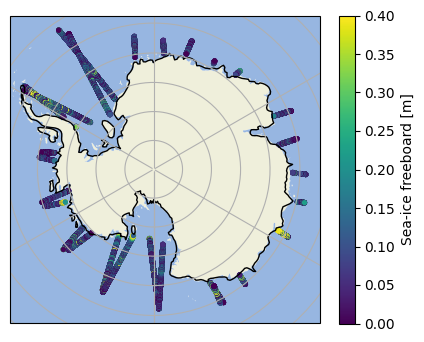

In [13]:
# Below, we plot the non-NaN values of the sea-ice freeboard on the map of the Antarctic region
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming lon_clean, lat_clean, and ifb_clean are the cleaned NumPy arrays
# Define the projection as Stereographic for the Antarctic region
proj = ccrs.SouthPolarStereo()

# Create a plot with the Antarctic stereographic projection
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': proj})

# Add coastlines and gridlines
ax.coastlines(resolution='110m')
ax.gridlines()

# Add features such as land, ocean, and borders
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the spatial distribution of ifb_clean on the Antarctic map
# The projection transform ensures the correct placement of lat/lon data
sc = ax.scatter(lon_clean, lat_clean, c=ifb_clean, cmap='viridis', 
                s=8, transform=ccrs.PlateCarree(), vmin=0.0, vmax=0.4)  # You can adjust 's' for marker size

# Add a colorbar to indicate the values of ifb_clean
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.8)
cbar.set_label('Sea-ice freeboard [m]')

# Set the title and show the plot
#ax.set_title('Spatial Distribution of IFB on the Antarctic Region')
plt.show()


In [14]:
# Now we look at the properties of cleaned sea-ice freeboards
ifb_clean

masked_array(data=[-0.14131781458854675, 0.13198231160640717,
                   0.15281401574611664, ..., -0.23384594917297363,
                   -0.19308580458164215, -0.2289179265499115],
             mask=[False, False, False, ..., False, False, False],
       fill_value=nan)

In [17]:
# We transfrom the cleaned sea-ice freeboard, latitude and longitude from masked array to numpy array
ifb_clean = np.array(ifb_clean)
lon_clean = np.array(lon_clean)
lat_clean = np.array(lat_clean)

In [38]:
# Project the 1D sea-ice freeboards onto EASE2 Polar Southern Hemisphere 50 km Grid
import pyresample

# Define the original swath area (lat_clean and lon_clean are the original points)
swath_def = pyresample.geometry.SwathDefinition(lons=lon_clean, lats=lat_clean)

# Define the EASE2 50 km grid for Polar Southern Hemisphere
# Assuming ease_lat and ease_lon are 2D latitude and longitude arrays for the grid
ease_grid_def = pyresample.geometry.GridDefinition(lons=ease_lon, lats=ease_lat)

# Perform the resampling using nearest neighbor or bilinear method
ifb_clean_2d = pyresample.kd_tree.resample_nearest(
    source_geo_def=swath_def,
    target_geo_def=ease_grid_def,
    data=ifb_clean,
    radius_of_influence=50000,  # Set radius of influence, e.g., 50 km
    fill_value=np.nan
)

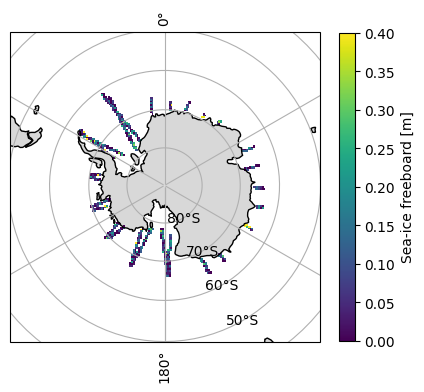

In [43]:
# Below we plot the spatial distribution of the sea-ice freeboard values on the EASE2 50 km grid
# Set up the plot
plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

# Plot the data using pcolormesh
# Note: Use transform=ccrs.PlateCarree() because ease_lat and ease_lon are in geographic coordinates
mesh = ax.pcolormesh(ease_lon, ease_lat, ifb_clean_2d, transform=ccrs.PlateCarree(), cmap='viridis', vmin=0.0, vmax=0.4)

# Add coastlines and other map features
ax.coastlines(resolution='110m', color='black')
ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)
ax.gridlines(draw_labels=True)

# Set plot extent (focus on the Antarctic region)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

# Add colorbar
plt.colorbar(mesh, ax=ax, orientation='vertical', label='Sea-ice freeboard [m]', shrink=0.8)

# Add title
#plt.title('Spatial Distribution of Projected Sea-Ice Freeboard on Antarctic Map')

# Show the plot
plt.show()

In [44]:
# Below, we try another cryo-tempo file on 01/05/2013 to check if they can be calculated over each other
cryotempo20130601 = Dataset(r'C:\Users\xliu38\OneDrive - University of Tasmania\PhD_data\cryotempo\tempo_poca_si\daily_l2p\cryotempo_20130601_combined_variables.nc')

# Reading the variables
lon_0601 = cryotempo20130601['longitude'][:] 
lat_0601 = cryotempo20130601['latitude'][:] 

ifb_0601 = cryotempo20130601['sea_ice_freeboard'][:]

# Create a mask that identifies positions where none of the arrays have NaN values
mask = ~np.isnan(lon_0601) & ~np.isnan(lat_0601) & ~np.isnan(ifb_0601)

# Apply the mask to each array to filter out NaN values
lon_0601_clean = lon_0601[mask]
lat_0601_clean = lat_0601[mask]
ifb_0601_clean = ifb_0601[mask]

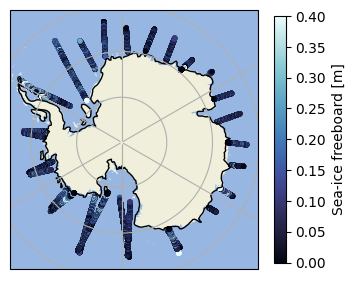

In [48]:
# Define the projection as Stereographic for the Antarctic region
import cmocean as cmo

proj = ccrs.SouthPolarStereo()

# Create a plot with the Antarctic stereographic projection
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={'projection': proj})

# Add coastlines and gridlines
ax.coastlines(resolution='110m')
ax.gridlines()

# Add features such as land, ocean, and borders
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the spatial distribution of ifb_clean on the Antarctic map
# The projection transform ensures the correct placement of lat/lon data
sc = ax.scatter(lon_0601_clean, lat_0601_clean, c=ifb_0601_clean, cmap='cmo.ice', 
                s=8, transform=ccrs.PlateCarree(), vmin=0.0, vmax=0.4)  # You can adjust 's' for marker size

# Add a colorbar to indicate the values of ifb_clean
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.8)
cbar.set_label('Sea-ice freeboard [m]')

# Set the title and show the plot
#ax.set_title('Spatial Distribution of IFB on the Antarctic Region')
plt.show()

In [50]:
# Define the original swath area (lat_clean and lon_clean are the original points)
swath_def_0601 = pyresample.geometry.SwathDefinition(lons=lon_0601_clean, lats=lat_0601_clean)

# Define the EASE2 50 km grid for Polar Southern Hemisphere
# Assuming ease_lat and ease_lon are 2D latitude and longitude arrays for the grid
ease_grid_def = pyresample.geometry.GridDefinition(lons=ease_lon, lats=ease_lat)

# Perform the resampling using nearest neighbor or bilinear method
ifb_clean_0601_2d = pyresample.kd_tree.resample_nearest(
    source_geo_def=swath_def_0601,
    target_geo_def=ease_grid_def,
    data=ifb_0601_clean,
    radius_of_influence=50000,  # Set radius of influence, e.g., 50 km
    fill_value=np.nan
)

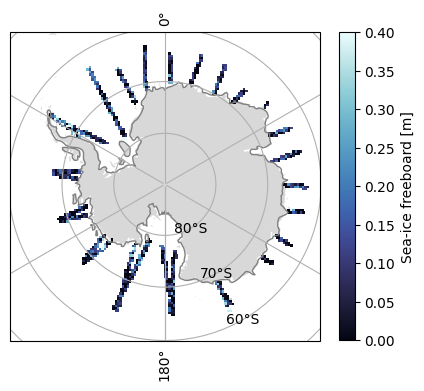

In [52]:
# Below we plot the spatial distribution of the sea-ice freeboard values on the EASE2 50 km grid
# Set up the plot
plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

# Plot the data using pcolormesh
# Note: Use transform=ccrs.PlateCarree() because ease_lat and ease_lon are in geographic coordinates
mesh = ax.pcolormesh(ease_lon, ease_lat, ifb_clean_0601_2d, transform=ccrs.PlateCarree(), cmap='cmo.ice', vmin=0.0, vmax=0.4)

# Add coastlines and other map features
ax.coastlines(resolution='110m', color='gray')
ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)
ax.gridlines(draw_labels=True)

# Set plot extent (focus on the Antarctic region)
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

# Add colorbar
plt.colorbar(mesh, ax=ax, orientation='vertical', label='Sea-ice freeboard [m]', shrink=0.8)

# Add title
#plt.title('Spatial Distribution of Projected Sea-Ice Freeboard on Antarctic Map')

# Show the plot
plt.show()

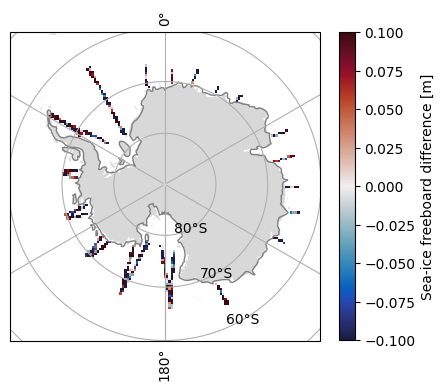

In [53]:
# Below, we try to plot the difference between the sea-ice freeboard values of the two files

# Calculate the difference between the two sea-ice freeboard arrays
ifb_diff = ifb_clean_0601_2d - ifb_clean_2d

# Set up the plot
plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

# Plot the data using pcolormesh
# Note: Use transform=ccrs.PlateCarree() because ease_lat and ease_lon are in geographic coordinates
mesh = ax.pcolormesh(ease_lon, ease_lat, ifb_diff, transform=ccrs.PlateCarree(), cmap='cmo.balance', vmin=-0.1, vmax=0.1)

# Add coastlines and other map features
ax.coastlines(resolution='110m', color='gray')
ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)
ax.gridlines(draw_labels=True)

# Set plot extent (focus on the Antarctic region)
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

# Add colorbar
plt.colorbar(mesh, ax=ax, orientation='vertical', label='Sea-ice freeboard difference [m]', shrink=0.8)

# Add title
#plt.title('Difference in Sea-Ice Freeboard between 01/05/2013 and 01/06/2013')

# Show the plot
plt.show()

In [58]:
ease_lat

array([[-16.42470792, -16.82196022, -17.21631972, ..., -17.60778693,
        -17.21631972, -16.82196022],
       [-16.82196022, -17.22002648, -17.61521605, ..., -18.00752919,
        -17.61521605, -17.22002648],
       [-17.21631972, -17.61521605, -18.01125184, ..., -18.4044271 ,
        -18.01125184, -17.61521605],
       ...,
       [-17.60778693, -18.00752919, -18.4044271 , ..., -18.79848042,
        -18.4044271 , -18.00752919],
       [-17.21631972, -17.61521605, -18.01125184, ..., -18.4044271 ,
        -18.01125184, -17.61521605],
       [-16.82196022, -17.22002648, -17.61521605, ..., -18.00752919,
        -17.61521605, -17.22002648]])

##### Below, we load all the daily variables from the Cryo-TEMPO products, project them onto the CCI grid to ge the daily regridded variables and then calculate the monthly-mean variables.

###### Firstly, try the radar freeboard variable.

In [63]:
import os
import glob
import xarray as xr

# Define the directory containing the daily-resolution datasets for May 2013
data_directory = r'C:\Users\xliu38\OneDrive - University of Tasmania\PhD_data\cryotempo\tempo_poca_si\daily_l2p\2013\05'

# Define EASE2 50 km grid
ease_grid_def = pyresample.geometry.GridDefinition(lons=ease_lon, lats=ease_lat)

# List of all daily .nc files in the directory
file_list = sorted(glob.glob(os.path.join(data_directory, 'cryotempo_201305*_combined_variables.nc')))

# Initialize an empty list to store the projected daily radar freeboard
projected_data_list = []

# Loop through all files
for file_path in file_list:
    # Load the dataset
    ds = xr.open_dataset(file_path)
    
    # Extract radar_freeboard, latitude, and longitude
    radar_freeboard = ds['radar_freeboard'].values
    latitude = ds['latitude'].values
    longitude = ds['longitude'].values
    
    # Remove NaN values
    valid_mask = ~np.isnan(radar_freeboard)
    radar_freeboard = radar_freeboard[valid_mask]
    latitude = latitude[valid_mask]
    longitude = longitude[valid_mask]

    # Define the original swath with valid points
    swath_def = pyresample.geometry.SwathDefinition(lons=longitude, lats=latitude)

    # Project radar_freeboard onto the EASE2 50 km grid using pyresample
    radar_freeboard_proj = pyresample.kd_tree.resample_nearest(
        source_geo_def=swath_def,
        target_geo_def=ease_grid_def,
        data=radar_freeboard,
        radius_of_influence=50000,  # Set radius of influence (50 km)
        fill_value=np.nan
    )
    
    # Append the projected radar freeboard to the list
    projected_data_list.append(radar_freeboard_proj)

# Stack all projected radar freeboards along a new axis (time axis)
projected_data_stack = np.array(projected_data_list)

# Calculate the monthly mean, ignoring NaN values
monthly_mean_radar_freeboard = np.nanmean(projected_data_stack, axis=0)

C:\Users\xliu38\AppData\Local\Temp\ipykernel_14072\2152104904.py:52: RuntimeWarning: Mean of empty slice
  monthly_mean_radar_freeboard = np.nanmean(projected_data_stack, axis=0)


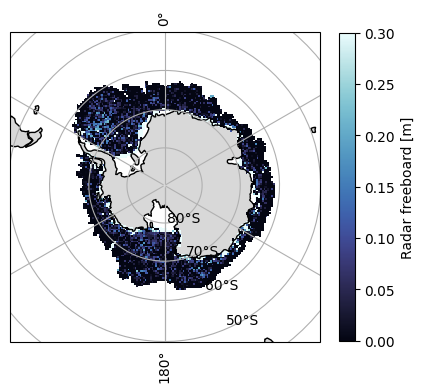

In [67]:
# Plot the monthly mean radar freeboard on the Antarctic map for check

plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

# Plot the data using pcolormesh
mesh = ax.pcolormesh(ease_lon, ease_lat, monthly_mean_radar_freeboard, transform=ccrs.PlateCarree(), cmap='cmo.ice', vmin=0.0, vmax=0.3)

# Add coastlines and other map features
ax.coastlines(resolution='110m', color='black')
ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)
ax.gridlines(draw_labels=True)

# Set plot extent (focus on the Antarctic region)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

# Add colorbar
plt.colorbar(mesh, ax=ax, orientation='vertical', label='Radar freeboard [m]', shrink=0.8)

# Add title
#plt.title('Monthly Mean Radar Freeboard - May 2013 on Antarctic Map')

# Show the plot
plt.show()

In [79]:
# Below we try to calculate the difference between the CCI and Cryo-TEMPO radar freeboard values

# Define the directory and file paths
cci_data_path = r'C:\Users\xliu38\Desktop\PhD_data\ESA_CCI_sea_ice\sea_ice_thickness_v3\l3c\env_cs2\ESACCI-SEAICE-L3C-SITHICK-SIRAL_CRYOSAT2-SH50KMEASE2-201305-fv3p0.nc'

# Load the CCI dataset
cci_ds = xr.open_dataset(cci_data_path)
cci_radar_freeboard = cci_ds['radar_freeboard'].values
cci_lon = cci_ds['lon'].values
cci_lat = cci_ds['lat'].values

# Calculate the difference between CCI and Cryo-TEMPO radar freeboards
# Assuming cci_radar_freeboard has the shape (1, 216, 216)
cci_radar_freeboard_2d = np.squeeze(cci_radar_freeboard, axis=0)
radar_freeboard_diff = monthly_mean_radar_freeboard - cci_radar_freeboard_2d

radar_freeboard_diff

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [82]:
# Below, we show the properties of the radar freeboard difference
radar_freeboard_diff.shape

(216, 216)

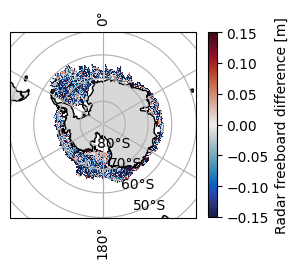

In [85]:
# Plot the monthly mean radar freeboard on the Antarctic map for check

plt.figure(figsize=(3, 3))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

# Plot the data using pcolormesh
mesh = ax.pcolormesh(ease_lon, ease_lat, radar_freeboard_diff, transform=ccrs.PlateCarree(), cmap='cmo.balance', vmin=-0.15, vmax=0.15)

# Add coastlines and other map features
ax.coastlines(resolution='110m', color='black')
ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)
ax.gridlines(draw_labels=True)

# Set plot extent (focus on the Antarctic region)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

# Add colorbar
plt.colorbar(mesh, ax=ax, orientation='vertical', label='Radar freeboard difference [m]', shrink=0.8)

# Add title
#plt.title('Monthly Mean Radar Freeboard - May 2013 on Antarctic Map')

# Show the plot
plt.show()

In [86]:
# Below, we project all the variables in the Cryo-TEMPO files to the EASE2 50 km grid

# Define the directory containing the daily-resolution datasets for May 2013
data_directory = r'C:\Users\xliu38\OneDrive - University of Tasmania\PhD_data\cryotempo\tempo_poca_si\daily_l2p\2013\05'

# Define EASE2 50 km grid
ease_grid_def = pyresample.geometry.GridDefinition(lons=ease_lon, lats=ease_lat)

# List of all daily .nc files in the directory
file_list = sorted(glob.glob(os.path.join(data_directory, 'cryotempo_201305*_combined_variables.nc')))

# Variables to project and calculate monthly means
variables = ['radar_freeboard', 'radar_freeboard_uncertainty', 'sea_ice_freeboard', 'sea_ice_freeboard_uncertainty', 'snow_depth', 'snow_depth_uncertainty']

# Initialize an empty dictionary to store the projected daily values for each variable
projected_data_dict = {var: [] for var in variables}

# Loop through all files
for file_path in file_list:
    # Load the dataset
    ds = xr.open_dataset(file_path)
    
    for var in variables:
        # Extract the variable, latitude, and longitude
        variable_data = ds[var].values
        latitude = ds['latitude'].values
        longitude = ds['longitude'].values

        # Remove NaN values
        valid_mask = ~np.isnan(variable_data)
        variable_data = variable_data[valid_mask]
        latitude = latitude[valid_mask]
        longitude = longitude[valid_mask]

        # Define the original swath with valid points
        swath_def = pyresample.geometry.SwathDefinition(lons=longitude, lats=latitude)

        # Project the variable onto the EASE2 50 km grid using pyresample
        projected_data = pyresample.kd_tree.resample_nearest(
            source_geo_def=swath_def,
            target_geo_def=ease_grid_def,
            data=variable_data,
            radius_of_influence=50000,  # Set radius of influence (50 km)
            fill_value=np.nan
        )

        # Append the projected data to the corresponding list in the dictionary
        projected_data_dict[var].append(projected_data)

# Stack all projected data along a new axis (time axis) and calculate the monthly mean for each variable
monthly_mean_data = {}
for var in variables:
    # Stack along the time axis
    projected_data_stack = np.array(projected_data_dict[var])

    # Calculate the monthly mean, ignoring NaN values
    monthly_mean_data[var] = np.nanmean(projected_data_stack, axis=0)

# Define the output directory and file path for saving the combined variables
output_directory = r'C:\Users\xliu38\OneDrive - University of Tasmania\PhD_data\cryotempo\tempo_poca_si\monthly'
output_file_path = os.path.join(output_directory, 'cryotempo_201305_combined_variables.nc')

# Create a dataset for the monthly mean variables
monthly_mean_ds = xr.Dataset(
    {
        'radar_freeboard': (['lat', 'lon'], monthly_mean_data['radar_freeboard']),
        'radar_freeboard_uncertainty': (['lat', 'lon'], monthly_mean_data['radar_freeboard_uncertainty']),
        'sea_ice_freeboard': (['lat', 'lon'], monthly_mean_data['sea_ice_freeboard']),
        'sea_ice_freeboard_uncertainty': (['lat', 'lon'], monthly_mean_data['sea_ice_freeboard_uncertainty']),
        'snow_depth': (['lat', 'lon'], monthly_mean_data['snow_depth']),
        'snow_depth_uncertainty': (['lat', 'lon'], monthly_mean_data['snow_depth_uncertainty']),
    },
    coords={
        'lon': (['lat', 'lon'], ease_lon),
        'lat': (['lat', 'lon'], ease_lat),
    },
    attrs={
        'title': 'Cryo-TEMPO Monthly Mean Variables for May 2013',
        'source': 'Cryo-TEMPO Daily Datasets for May 2013 Projected onto EASE2 50 km Grid',
        'description': 'Monthly mean values of radar_freeboard, radar_freeboard_uncertainty, sea_ice_freeboard, sea_ice_freeboard_uncertainty, snow_depth, and snow_depth_uncertainty.',
        'month': 'May 2013',
    }
)

# Save the dataset to a NetCDF file
monthly_mean_ds.to_netcdf(output_file_path)
print(f"Monthly mean variables saved to: {output_file_path}")

Monthly mean variables saved to: C:\Users\xliu38\OneDrive - University of Tasmania\PhD_data\cryotempo\tempo_poca_si\monthly\cryotempo_201305_combined_variables.nc


C:\Users\xliu38\AppData\Local\Temp\ipykernel_14072\1345913979.py:57: RuntimeWarning: Mean of empty slice
  monthly_mean_data[var] = np.nanmean(projected_data_stack, axis=0)


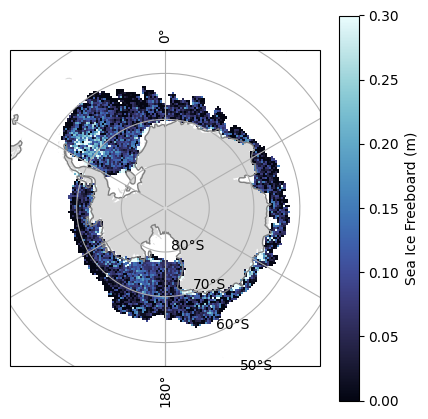

In [87]:
# We load the saved monthly mean variables and plot the sea-ice freeboard

# Define the directory and file path
file_path = r'C:\Users\xliu38\OneDrive - University of Tasmania\PhD_data\cryotempo\tempo_poca_si\monthly\cryotempo_201305_combined_variables.nc'

# Load the dataset
ds = xr.open_dataset(file_path)

# Extract the variable 'sea_ice_freeboard', latitude ('lat'), and longitude ('lon')
sea_ice_freeboard = ds['sea_ice_freeboard'].values
lat = ds['lat'].values
lon = ds['lon'].values

# Plot the 'sea_ice_freeboard' on the map of the Antarctic region
plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

# Plot the data using pcolormesh
mesh = ax.pcolormesh(lon, lat, sea_ice_freeboard, transform=ccrs.PlateCarree(), cmap='cmo.ice', vmin=0.0, vmax=0.3)

# Add coastlines and other map features
ax.coastlines(resolution='110m', color='gray')
ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)
ax.gridlines(draw_labels=True)

# Set plot extent (focus on the Antarctic region)
ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())

# Add colorbar
plt.colorbar(mesh, ax=ax, orientation='vertical', label='Sea Ice Freeboard (m)')

# Add title
#plt.title('Sea Ice Freeboard - May 2013 on Antarctic Map')

# Show the plot
plt.show()

##### Below, we apply what we have done successfully for May 2013 to all the daily datasets during the CryoSat-2 common winter to get the entirely monthly datasets across the same period.

In [ ]:
# Define the main directories
base_directory = r'C:\Users\xliu38\OneDrive - University of Tasmania\PhD_data\cryotempo\tempo_poca_si\daily_l2p'
output_directory = r'C:\Users\xliu38\OneDrive - University of Tasmania\PhD_data\cryotempo\tempo_poca_si\monthly'

# Define the EASE2 50 km grid (assuming these are already defined as 2D arrays)
ease_grid_def = pyresample.geometry.GridDefinition(lons=ease_lon, lats=ease_lat)

# Define variables to project and calculate monthly means
variables = [
    'radar_freeboard', 'radar_freeboard_uncertainty',
    'sea_ice_freeboard', 'sea_ice_freeboard_uncertainty',
    'snow_depth', 'snow_depth_uncertainty'
]

# Loop through each year and month to process the datasets
for year in range(2013, 2019):
    for month in range(5, 11):  # May to October (months 05 to 10)
        # Skip May 2013 as it has already been processed
        if year == 2013 and month == 5:
            continue

        # Define the monthly directory path
        month_str = f'{month:02d}'  # Format month as two digits
        year_month_directory = os.path.join(base_directory, f'{year}', month_str)

        # List all daily .nc files in the directory for that month
        file_list = sorted(glob.glob(os.path.join(year_month_directory, f'cryotempo_{year}{month_str}*_combined_variables.nc')))
        
        if not file_list:
            # Skip if no files are found for the given year and month
            print(f'No data found for {year}-{month_str}. Skipping...')
            continue

        # Initialize an empty dictionary to store the projected daily values for each variable
        projected_data_dict = {var: [] for var in variables}

        # Loop through all files for that month
        for file_path in file_list:
            # Load the dataset
            ds = xr.open_dataset(file_path)
            
            for var in variables:
                # Extract the variable, latitude, and longitude
                variable_data = ds[var].values
                latitude = ds['latitude'].values
                longitude = ds['longitude'].values

                # Remove NaN values
                valid_mask = ~np.isnan(variable_data)
                variable_data = variable_data[valid_mask]
                latitude = latitude[valid_mask]
                longitude = longitude[valid_mask]

                # Define the original swath with valid points
                swath_def = pyresample.geometry.SwathDefinition(lons=longitude, lats=latitude)

                # Project the variable onto the EASE2 50 km grid using pyresample
                projected_data = pyresample.kd_tree.resample_nearest(
                    source_geo_def=swath_def,
                    target_geo_def=ease_grid_def,
                    data=variable_data,
                    radius_of_influence=50000,  # Set radius of influence (50 km)
                    fill_value=np.nan
                )

                # Append the projected data to the corresponding list in the dictionary
                projected_data_dict[var].append(projected_data)

        # Stack all projected data along a new axis (time axis) and calculate the monthly mean for each variable
        monthly_mean_data = {}
        for var in variables:
            # Stack along the time axis
            projected_data_stack = np.array(projected_data_dict[var])

            # Calculate the monthly mean, ignoring NaN values
            monthly_mean_data[var] = np.nanmean(projected_data_stack, axis=0)

        # Define output file path for saving the combined variables
        output_file_name = f'cryotempo_{year}{month_str}_combined_variables.nc'
        output_file_path = os.path.join(output_directory, output_file_name)

        # Create a dataset for the monthly mean variables
        monthly_mean_ds = xr.Dataset(
            {
                'radar_freeboard': (['lat', 'lon'], monthly_mean_data['radar_freeboard']),
                'radar_freeboard_uncertainty': (['lat', 'lon'], monthly_mean_data['radar_freeboard_uncertainty']),
                'sea_ice_freeboard': (['lat', 'lon'], monthly_mean_data['sea_ice_freeboard']),
                'sea_ice_freeboard_uncertainty': (['lat', 'lon'], monthly_mean_data['sea_ice_freeboard_uncertainty']),
                'snow_depth': (['lat', 'lon'], monthly_mean_data['snow_depth']),
                'snow_depth_uncertainty': (['lat', 'lon'], monthly_mean_data['snow_depth_uncertainty']),
            },
            coords={
                'lon': (['lat', 'lon'], ease_lon),
                'lat': (['lat', 'lon'], ease_lat),
            },
            attrs={
                'title': f'Cryo-TEMPO Monthly Mean Variables for {year}-{month_str}',
                'source': f'Cryo-TEMPO Daily Datasets for {year}-{month_str} Projected onto EASE2 50 km Grid',
                'description': 'Monthly mean values of radar_freeboard, radar_freeboard_uncertainty, sea_ice_freeboard, sea_ice_freeboard_uncertainty, snow_depth, and snow_depth_uncertainty.',
                'month': f'{year}-{month_str}',
            }
        )

        # Save the dataset to a NetCDF file
        monthly_mean_ds.to_netcdf(output_file_path)
        print(f"Monthly mean variables saved to: {output_file_path}")

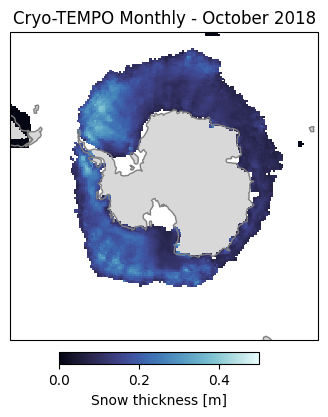

In [258]:
# Define the directory containing the datasets
data_directory = r'C:\Users\xliu38\OneDrive - University of Tasmania\PhD_data\cryotempo\tempo_poca_si\monthly'

# Load the dataset for May 2013
file_path = os.path.join(data_directory, 'cryotempo_201810_combined_variables.nc')
ds = xr.open_dataset(file_path)

# Extract radar_freeboard, latitude, and longitude
var = ds['snow_depth'].values  # (lat, lon)
lat = ds['lat'].values
lon = ds['lon'].values

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={'projection': ccrs.SouthPolarStereo()})
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])  # Position for the colorbar

# Plot the spatial distribution of radar freeboard
ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m', color='gray')
ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)

# Plot the data using pcolormesh
mesh = ax.pcolormesh(
    lon, lat, var, 
    transform=ccrs.PlateCarree(), cmap='cmo.ice', vmin=0, vmax=0.5
)
ax.set_title('Cryo-TEMPO Monthly - October 2018')

# Add colorbar
fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal', label='Snow thickness [m]')

# Show the plot
plt.show()

In [91]:
# Below, we extract the variables and project them onto the EASE2 50 km grid

# Now we start from LEGOS data over both Envisat and CryoSat-2 common winters

# Define the directory containing the datasets
data_directory = r'C:\Users\xliu38\Desktop\PhD_data\aviso_cryosat-2'

# List of dataset filenames and output names
datasets = [
    ("SIT_SH_2002_2011_ENV_SnowAMSR.ease2_12500_smth25000.nc", "SIT_SH_2002_2011_ENV_SnowAMSR_projected.nc"),
    ("SIT_SH_2010_2018_CS2_SnowAMSR.ease2_12500_smth25000.nc", "SIT_SH_2010_2018_CS2_SnowAMSR_projected.nc"),
    ("SIT_SH_2013_2018_CS2_SnowKaKu.ease2_12500_smth25000.nc", "SIT_SH_2013_2018_CS2_SnowKaKu_projected.nc")
]

# Variables to load and project
variables = [
    'freeboard_ice', 'freeboard_ice_unc', 'freeboard_radar', 'freeboard_radar_unc',
    'freeboard_tot', 'freeboard_tot_unc', 'snow_depth', 'snow_depth_unc'
]

# Define the EASE2 50 km grid (assuming these are already defined as 2D arrays)
ease_grid_def = pyresample.geometry.GridDefinition(lons=ease_lon, lats=ease_lat)

# Loop through each dataset
for dataset_filename, output_filename in datasets:
    # Define the dataset path
    dataset_path = os.path.join(data_directory, dataset_filename)
    
    # Load the dataset
    ds = xr.open_dataset(dataset_path)

    # Initialize an empty dictionary to store the projected variables
    projected_vars = {var: [] for var in variables}

    # Get the latitude and longitude from the dataset (assuming they are named 'latitude' and 'longitude')
    latitude = ds['latitude'].values  # (850, 850)
    longitude = ds['longitude'].values  # (850, 850)

    # Define the original swath grid
    swath_def = pyresample.geometry.SwathDefinition(lons=longitude, lats=latitude)

    # Loop through each time step
    for t in range(ds.dims['time']):
        # Project each variable for the current time step
        for var in variables:
            # Extract the variable data for the current time step
            var_data = ds[var].isel(time=t).values  # (850, 850)

            # Get the _FillValue from the variable's attributes if it exists
            fill_value = ds[var].attrs.get('_FillValue', np.nan)

            # Remove NaN values or the _FillValue
            valid_mask = (var_data != fill_value) & ~np.isnan(var_data)
            valid_var_data = var_data[valid_mask]
            valid_lat = latitude[valid_mask]
            valid_lon = longitude[valid_mask]

            # Check if there is valid data to project
            if valid_var_data.size == 0:
                # If there are no valid data points, create an empty array of NaNs for the projected data
                projected_data = np.full_like(ease_lon, np.nan)
            else:
                # Define the original swath with valid points
                valid_swath_def = pyresample.geometry.SwathDefinition(lons=valid_lon, lats=valid_lat)

                # Project the variable onto the EASE2 50 km grid using pyresample
                projected_data = pyresample.kd_tree.resample_nearest(
                    source_geo_def=valid_swath_def,
                    target_geo_def=ease_grid_def,
                    data=valid_var_data,
                    radius_of_influence=50000,  # Set radius of influence (50 km)
                    fill_value=np.nan
                )

            # Append the projected data to the corresponding list in the dictionary
            projected_vars[var].append(projected_data)

    # Create a new xarray.Dataset to store the projected variables
    projected_ds = xr.Dataset(
        {var: (['time', 'lat', 'lon'], np.array(projected_vars[var])) for var in variables},
        coords={
            'time': ds['time'],
            'lat': (['lat', 'lon'], ease_lat),
            'lon': (['lat', 'lon'], ease_lon),
        },
        attrs={
            'title': f'Projected LEGOS Variables from {dataset_filename}',
            'source': 'Projected from original LEGOS dataset to EASE2 50 km grid',
            'description': 'Projected variables: freeboard_ice, freeboard_ice_unc, freeboard_radar, freeboard_radar_unc, freeboard_tot, freeboard_tot_unc, snow_depth, and snow_depth_unc.',
        }
    )

    # Define the output file path
    output_file_path = os.path.join(data_directory, output_filename)

    # Save the projected dataset to a NetCDF file
    projected_ds.to_netcdf(output_file_path)
    print(f"Projected dataset saved to: {output_file_path}")

C:\Users\xliu38\AppData\Local\Temp\ipykernel_14072\3840282827.py:43: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):


Projected dataset saved to: C:\Users\xliu38\Desktop\PhD_data\aviso_cryosat-2\SIT_SH_2002_2011_ENV_SnowAMSR_projected.nc


C:\Users\xliu38\AppData\Local\Temp\ipykernel_14072\3840282827.py:43: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):


Projected dataset saved to: C:\Users\xliu38\Desktop\PhD_data\aviso_cryosat-2\SIT_SH_2010_2018_CS2_SnowAMSR_projected.nc


C:\Users\xliu38\AppData\Local\Temp\ipykernel_14072\3840282827.py:43: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):


Projected dataset saved to: C:\Users\xliu38\Desktop\PhD_data\aviso_cryosat-2\SIT_SH_2013_2018_CS2_SnowKaKu_projected.nc


GIF saved to: C:\Users\xliu38\Desktop\PhD_data\aviso_cryosat-2\legos2_cs2_spat_dist_sd.gif


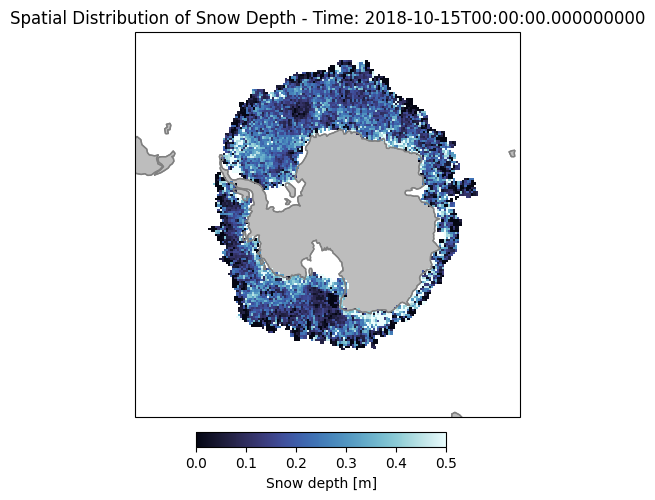

In [116]:
# Below, we plot these projected LEGOS variables onto the CCI grid for check
import matplotlib.animation as animation

# Define the directory and file path
data_directory = r'C:\Users\xliu38\Desktop\PhD_data\aviso_cryosat-2'
dataset_path = os.path.join(data_directory, 'SIT_SH_2013_2018_CS2_SnowKaKu_projected.nc')

# Load the dataset
ds = xr.open_dataset(dataset_path)

# Extract the variable 'freeboard_ice', latitude ('lat'), and longitude ('lon')
freeboard_ice = ds['snow_depth'].values  # (time, lat, lon)
lat = ds['lat'].values
lon = ds['lon'].values
time = ds['time'].values

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': ccrs.SouthPolarStereo()})
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])  # Position for the colorbar

# Function to initialize the map for plotting
def init():
    ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', color='gray')
    ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)
    return ax

# Function to update each frame of the animation
def update(frame):
    ax.clear()  # Clear previous plot
    ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', color='gray')
    ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)
    
    # Plot the current frame data using pcolormesh
    mesh = ax.pcolormesh(
        lon, lat, freeboard_ice[frame, :, :], 
        transform=ccrs.PlateCarree(), cmap='cmo.ice', vmin=0, vmax=0.5
    )
    ax.set_title(f'Spatial Distribution of Snow Depth - Time: {str(time[frame])}')

    # Add colorbar
    fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal', label='Snow depth [m]')
    
    return mesh

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(time), init_func=init, blit=False, repeat=False
)

# Save the animation as a gif file
gif_output_path = os.path.join(data_directory, 'legos2_cs2_spat_dist_sd.gif')
ani.save(gif_output_path, writer='pillow', fps=2)

print(f"GIF saved to: {gif_output_path}")

##### Below, we project the CSAO datasets onto the CCI grid and also create a video for them to check

In [95]:
# Define the directory and file paths
data_directory = r'C:\Users\xliu38\Desktop\PhD_data\CSAO_sea_ice'
dataset_path = os.path.join(data_directory, 'csao_annual_means_2013_2018.nc')
output_file_path = os.path.join(data_directory, 'csao_annual_means_2013_2018_projected.nc')

# Load the dataset
ds = xr.open_dataset(dataset_path)

# Variables to project
variables = [
    'csao_radar_freeboard_unc_yr', 'csao_radar_freeboard_yr', 
    'csao_sea_ice_freeboard_unc_yr', 'csao_sea_ice_freeboard_yr', 
    'csao_snow_correction_yr', 'csao_snow_depth_unc_yr', 
    'csao_snow_depth_yr', 'csao_total_freeboard_unc_yr', 
    'csao_total_freeboard_yr'
]

# Define the EASE2 50 km grid (assuming these are already defined as 2D arrays)
ease_grid_def = pyresample.geometry.GridDefinition(lons=ease_lon, lats=ease_lat)

# Initialize an empty dictionary to store the projected variables
projected_vars = {var: [] for var in variables}

# Loop through each year (assuming the dataset has a 'year' dimension)
for year_idx in range(ds.dims['year']):
    # Loop through each variable to project it onto the EASE2 grid
    for var in variables:
        # Extract the variable data for the current year
        var_data = ds[var].isel(year=year_idx).values  # (y, x)

        # Get the latitude and longitude from the dataset
        latitude = ds['lat'].values  # (y, x)
        longitude = ds['lon'].values  # (y, x)

        # Remove NaN values or the _FillValue
        fill_value = ds[var].attrs.get('_FillValue', np.nan)
        valid_mask = (var_data != fill_value) & ~np.isnan(var_data)
        valid_var_data = var_data[valid_mask]
        valid_lat = latitude[valid_mask]
        valid_lon = longitude[valid_mask]

        # Check if there is valid data to project
        if valid_var_data.size == 0:
            # If there are no valid data points, create an empty array of NaNs for the projected data
            projected_data = np.full(ease_lon.shape, np.nan)
        else:
            # Define the original swath with valid points
            valid_swath_def = pyresample.geometry.SwathDefinition(lons=valid_lon, lats=valid_lat)

            # Project the variable onto the EASE2 50 km grid using pyresample
            projected_data = pyresample.kd_tree.resample_nearest(
                source_geo_def=valid_swath_def,
                target_geo_def=ease_grid_def,
                data=valid_var_data,
                radius_of_influence=50000,  # Set radius of influence (50 km)
                fill_value=np.nan
            )

        # Append the projected data to the corresponding list in the dictionary
        projected_vars[var].append(projected_data)

# Create a new xarray.Dataset to store the projected variables
projected_ds = xr.Dataset(
    {var: (['year', 'lat', 'lon'], np.array(projected_vars[var])) for var in variables},
    coords={
        'year': ds['year'],
        'lat': (['lat', 'lon'], ease_lat),
        'lon': (['lat', 'lon'], ease_lon),
    },
    attrs={
        'title': 'Projected CSAO Variables onto EASE2 50 km Grid',
        'source': 'Projected from original CSAO dataset to EASE2 50 km grid',
        'description': 'Projected variables: csao_radar_freeboard_unc_yr, csao_radar_freeboard_yr, csao_sea_ice_freeboard_unc_yr, csao_sea_ice_freeboard_yr, csao_snow_correction_yr, csao_snow_depth_unc_yr, csao_snow_depth_yr, csao_total_freeboard_unc_yr, and csao_total_freeboard_yr.',
    }
)

# Save the projected dataset to a NetCDF file
projected_ds.to_netcdf(output_file_path)
print(f"Projected dataset saved to: {output_file_path}")

C:\Users\xliu38\AppData\Local\Temp\ipykernel_14072\1229341337.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for year_idx in range(ds.dims['year']):


Projected dataset saved to: C:\Users\xliu38\Desktop\PhD_data\CSAO_sea_ice\csao_annual_means_2013_2018_projected.nc


GIF saved to: C:\Users\xliu38\Desktop\PhD_data\CSAO_sea_ice\csao_spat_dist_sc.gif


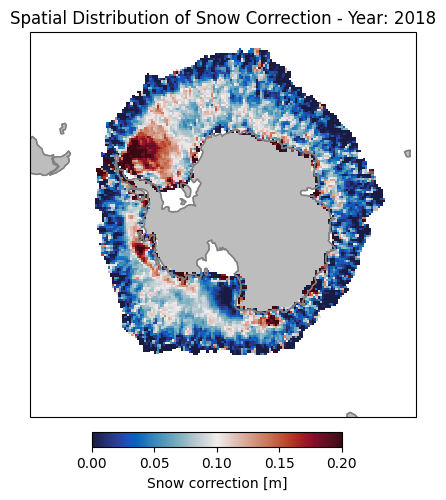

In [123]:
# Define the directory and file path
data_directory = r'C:\Users\xliu38\Desktop\PhD_data\CSAO_sea_ice'
dataset_path = os.path.join(data_directory, 'csao_annual_means_2013_2018_projected.nc')

# Load the dataset
ds = xr.open_dataset(dataset_path)

# Extract the variable 'csao_sea_ice_freeboard_yr', latitude ('lat'), and longitude ('lon')
var = ds['csao_snow_correction_yr'].values  # (year, lat, lon)
lat = ds['lat'].values
lon = ds['lon'].values
year = ds['year'].values

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': ccrs.SouthPolarStereo()})
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])  # Position for the colorbar

# Function to initialize the map for plotting
def init():
    ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', color='gray')
    ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)
    return ax

# Function to update each frame of the animation
def update(frame):
    ax.clear()  # Clear previous plot
    ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', color='gray')
    ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)
    
    # Plot the current frame data using pcolormesh
    mesh = ax.pcolormesh(
        lon, lat, var[frame, :, :], 
        transform=ccrs.PlateCarree(), cmap='cmo.balance', vmin=0, vmax=0.2
    )
    ax.set_title(f'Spatial Distribution of Snow Correction - Year: {str(year[frame])}')

    # Add colorbar
    fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal', label='Snow correction [m]')
    
    return mesh

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(year), init_func=init, blit=False, repeat=False
)

# Save the animation as a gif file
gif_output_path = os.path.join(data_directory, 'csao_spat_dist_sc.gif')
ani.save(gif_output_path, writer='pillow', fps=1)

print(f"GIF saved to: {gif_output_path}")

In [ ]:
# Below, we project the CSAO monthly datasets across the year interval 2013-2018 to the EASE2 50 km grid.

# Define the directory containing the datasets
data_directory = r'C:\Users\xliu38\Desktop\PhD_data\CSAO_sea_ice'

# List of dataset filenames from 2013 to 2018
years = list(range(2013, 2019))
datasets = [f"fb_sla_cs2_sam_{year}.nc" for year in years]

# Define the EASE2 50 km grid (assuming these are already defined as 2D arrays)
ease_grid_def = pyresample.geometry.GridDefinition(lons=ease_lon, lats=ease_lat)

# Loop through each dataset
for year, dataset_filename in zip(years, datasets):
    # Define the dataset path
    dataset_path = os.path.join(data_directory, dataset_filename)
    
    # Load the dataset
    ds = xr.open_dataset(dataset_path)

    # Determine the variables to project based on the year
    if year == 2017:
        variables = {
            'radar_freeboard_20hz_mean': 'radar_freeboard',
            'radar_freeboard_unc_20hz_mean': 'radar_freeboard_unc',
            'snow_depth_sd_ASD_sh': 'snow_depth'
        }
    else:
        variables = {
            'radar_freeboard_mean': 'radar_freeboard',
            'radar_freeboard_unc': 'radar_freeboard_unc',
            'snow_depth_ASD': 'snow_depth'
        }

    # Initialize an empty dictionary to store the projected variables
    projected_vars = {new_var: [] for new_var in variables.values()}

    # Get the latitude and longitude from the dataset
    latitude = ds['lat'].values  # (y, x)
    longitude = ds['lon'].values  # (y, x)

    # Define the original swath grid
    swath_def = pyresample.geometry.SwathDefinition(lons=longitude, lats=latitude)

    # Loop through each time step
    for t in range(ds.dims['time']):
        # Project each variable for the current time step
        for old_var, new_var in variables.items():
            # Extract the variable data for the current time step
            var_data = ds[old_var].isel(time=t).values  # (y, x)

            # Get the _FillValue from the variable's attributes if it exists
            fill_value = ds[old_var].attrs.get('_FillValue', np.nan)

            # Remove NaN values or the _FillValue
            valid_mask = (var_data != fill_value) & ~np.isnan(var_data)
            valid_var_data = var_data[valid_mask]
            valid_lat = latitude[valid_mask]
            valid_lon = longitude[valid_mask]

            # Check if there is valid data to project
            if valid_var_data.size == 0:
                # If there are no valid data points, create an empty array of NaNs for the projected data
                projected_data = np.full(ease_lon.shape, np.nan)
            else:
                # Define the original swath with valid points
                valid_swath_def = pyresample.geometry.SwathDefinition(lons=valid_lon, lats=valid_lat)

                # Project the variable onto the EASE2 50 km grid using pyresample
                projected_data = pyresample.kd_tree.resample_nearest(
                    source_geo_def=valid_swath_def,
                    target_geo_def=ease_grid_def,
                    data=valid_var_data,
                    radius_of_influence=50000,  # Set radius of influence (50 km)
                    fill_value=np.nan
                )

            # Append the projected data to the corresponding list in the dictionary
            projected_vars[new_var].append(projected_data)

    # Create a new xarray.Dataset to store the projected variables
    projected_ds = xr.Dataset(
        {new_var: (['time', 'lat', 'lon'], np.array(projected_vars[new_var])) for new_var in variables.values()},
        coords={
            'time': ds['time'],
            'lat': (['lat', 'lon'], ease_lat),
            'lon': (['lat', 'lon'], ease_lon),
        },
        attrs={
            'title': f'Projected CSAO Variables from {dataset_filename}',
            'source': 'Projected from original CSAO dataset to EASE2 50 km grid',
            'description': 'Projected variables: radar_freeboard, radar_freeboard_unc, and snow_depth.',
        }
    )

    # Save the projected dataset to a new NetCDF file
    output_file_path = os.path.join(data_directory, f'projected_{dataset_filename}')
    projected_ds.to_netcdf(output_file_path)
    print(f"Projected dataset saved to: {output_file_path}")

In [ ]:
# Below, we create an animation to visualize the projected radar freeboard from the CSAO datasets.

# Define the directory containing the projected datasets
data_directory = r'C:\Users\xliu38\Desktop\PhD_data\CSAO_sea_ice'

# List of projected dataset filenames from 2013 to 2018
years = list(range(2013, 2019))
datasets = [f"projected_fb_sla_cs2_sam_{year}.nc" for year in years]

# Loop through each dataset to create a .tif video for each year's monthly radar freeboard
for year, dataset_filename in zip(years, datasets):
    # Define the dataset path
    dataset_path = os.path.join(data_directory, dataset_filename)

    # Load the dataset
    ds = xr.open_dataset(dataset_path)

    # Extract the variable 'radar_freeboard', latitude ('lat'), and longitude ('lon')
    snow_depth = ds['snow_depth'].values  # (time, lat, lon)
    lat = ds['lat'].values
    lon = ds['lon'].values
    time = ds['time'].values

    # Set up the figure and axis for plotting
    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': ccrs.SouthPolarStereo()})
    cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])  # Position for the colorbar

    # Function to initialize the map for plotting
    def init():
        ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
        ax.coastlines(resolution='110m', color='gray')
        ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)
        return ax

    # Function to update each frame of the animation
    def update(frame):
        ax.clear()  # Clear previous plot
        ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
        ax.coastlines(resolution='110m', color='gray')
        ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)

        # Plot the current frame data using pcolormesh
        mesh = ax.pcolormesh(
            lon, lat, radar_freeboard[frame, :, :],
            transform=ccrs.PlateCarree(), cmap='cmo.ice', vmin=0, vmax=0.5
        )
        ax.set_title(f'Spatial Distribution of Snow Depth - {str(time[frame])}')

        # Add colorbar
        fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal', label='Snow depth [m]')

        return mesh

    # Create the animation
    ani = animation.FuncAnimation(
        fig, update, frames=len(time), init_func=init, blit=False, repeat=False
    )

    # Save the animation as a .tif file
    gif_output_path = os.path.join(data_directory, f'csao_spa_dist_sd_{year}.gif')
    ani.save(gif_output_path, writer='pillow', fps=1)

    print(f"GIF video saved to: {gif_output_path}")

##### Below, we plot the spatial distributions of CCI radar, sea-ice freeboards and snow thicknesses during both Envisat and CryoSat-2 common winters.

###### Firstly, Envisat common winter.

GIF video saved to: C:\Users\xliu38\Desktop\PhD_data\ESA_CCI_sea_ice\sea_ice_thickness_v3\l3c\env_cs2\cci_spa_dist_sd.gif


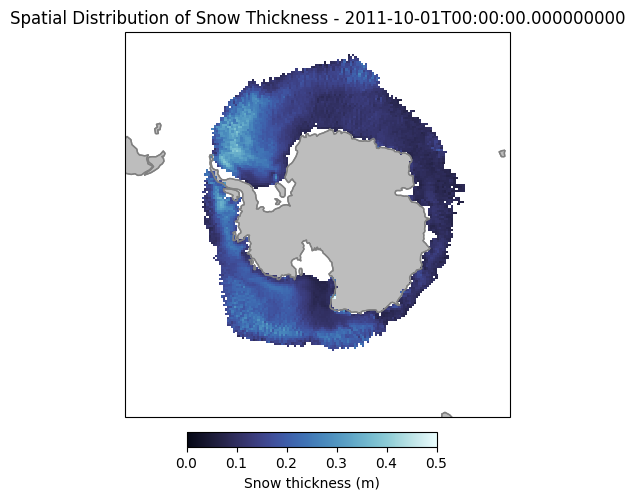

In [266]:
# Directory containing the datasets
data_directory = r'C:\Users\xliu38\Desktop\PhD_data\ESA_CCI_sea_ice\sea_ice_thickness_v3\l3c\env_cs2'

# Set date range from May to October between 2003 and 2011
start_year, end_year = 2003, 2011
months = ["05", "06", "07", "08", "09", "10"]

# Get all files in the directory
file_pattern = os.path.join(data_directory, "ESACCI-SEAICE-L3C-SITHICK-RA2_ENVISAT-SH50KMEASE2-*.nc")
files = sorted(glob.glob(file_pattern))

# Filter files based on the desired date range
selected_files = []
for file in files:
    year_month = os.path.basename(file).split('-')[6][:6]
    year = int(year_month[:4])
    month = year_month[4:]
    if start_year <= year <= end_year and month in months:
        selected_files.append(file)

# Load the "radar_freeboard" variable from each file
radar_freeboards = []
lats, lons, times = None, None, []
for file in selected_files:
    ds = xr.open_dataset(file)
    radar_freeboard = ds["snow_depth"].values  # (time, yc, xc)
    radar_freeboards.append(radar_freeboard)
    if lats is None and lons is None:
        lats, lons = ds["lat"].values, ds["lon"].values
    times.append(ds["time"].values)
    ds.close()

# Concatenate times along the time dimension
times = np.concatenate(times)

# Set up the figure and axis for plotting
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': ccrs.SouthPolarStereo()})
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])  # Position for the colorbar

# Function to initialize the map for plotting
def init():
    ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', color='gray')
    ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)
    return ax

# Function to update each frame of the animation
def update(frame):
    ax.clear()  # Clear previous plot
    ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', color='gray')
    ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)

    # Plot the current frame data using pcolormesh
    mesh = ax.pcolormesh(
        lons, lats, radar_freeboards[frame].squeeze(),
        transform=ccrs.PlateCarree(), cmap='cmo.ice', vmin=0, vmax=0.5
    )
    ax.set_title(f'Spatial Distribution of Snow Thickness - {str(times[frame])}')

    # Add colorbar
    fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal', label='Snow thickness (m)')

    return mesh

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(radar_freeboards), init_func=init, blit=False, repeat=False
)

# Save the animation as a .gif file
gif_output_path = os.path.join(data_directory, 'cci_spa_dist_sd.gif')
ani.save(gif_output_path, writer='pillow', fps=1)

print(f"GIF video saved to: {gif_output_path}")

##### Next, CryoSat-2 common winter.

GIF video saved to: C:\Users\xliu38\Desktop\PhD_data\ESA_CCI_sea_ice\sea_ice_thickness_v3\l3c\env_cs2\cci_cs2_spa_dist_sd.gif


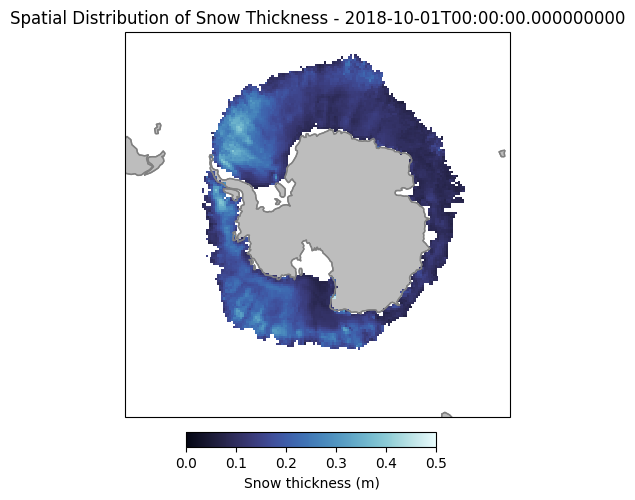

In [269]:
# Directory containing the datasets
data_directory = r'C:\Users\xliu38\Desktop\PhD_data\ESA_CCI_sea_ice\sea_ice_thickness_v3\l3c\env_cs2'

# Set date range from May to October between 2013 and 2018
start_year, end_year = 2013, 2018
months = ["05", "06", "07", "08", "09", "10"]

# Get all files in the directory
file_pattern = os.path.join(data_directory, "ESACCI-SEAICE-L3C-SITHICK-SIRAL_CRYOSAT2-SH50KMEASE2-*.nc")
files = sorted(glob.glob(file_pattern))

# Filter files based on the desired date range
selected_files = []
for file in files:
    year_month = os.path.basename(file).split('-')[6][:6]
    year = int(year_month[:4])
    month = year_month[4:]
    if start_year <= year <= end_year and month in months:
        selected_files.append(file)

# Load the "radar_freeboard" variable from each file
radar_freeboards = []
lats, lons, times = None, None, []
for file in selected_files:
    ds = xr.open_dataset(file)
    radar_freeboard = ds["snow_depth"].values  # (time, yc, xc)
    radar_freeboards.append(radar_freeboard)
    if lats is None and lons is None:
        lats, lons = ds["lat"].values, ds["lon"].values
    times.append(ds["time"].values)
    ds.close()

# Concatenate times along the time dimension
times = np.concatenate(times)

# Set up the figure and axis for plotting
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': ccrs.SouthPolarStereo()})
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])  # Position for the colorbar

# Function to initialize the map for plotting
def init():
    ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', color='gray')
    ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)
    return ax

# Function to update each frame of the animation
def update(frame):
    ax.clear()  # Clear previous plot
    ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', color='gray')
    ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)

    # Plot the current frame data using pcolormesh
    mesh = ax.pcolormesh(
        lons, lats, radar_freeboards[frame].squeeze(),
        transform=ccrs.PlateCarree(), cmap='cmo.ice', vmin=0, vmax=0.5
    )
    ax.set_title(f'Spatial Distribution of Snow Thickness - {str(times[frame])}')

    # Add colorbar
    fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal', label='Snow thickness (m)')

    return mesh

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(radar_freeboards), init_func=init, blit=False, repeat=False
)

# Save the animation as a .gif file
gif_output_path = os.path.join(data_directory, 'cci_cs2_spa_dist_sd.gif')
ani.save(gif_output_path, writer='pillow', fps=1)

print(f"GIF video saved to: {gif_output_path}")